In [1]:
from IPython.display import clear_output
import tensorflow as tf
print(tf.version)

<module 'tensorflow_core._api.v2.version' from '/home/sun/miniconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/_api/v2/version/__init__.py'>


## Tensorflow basics

In [2]:
string = tf.Variable("this is a string", tf.string) 
number = tf.Variable(324, tf.int16)
floating = tf.Variable(3.567, tf.float64)
rank2_tensor = tf.Variable([[1, 2], [3, 4]], tf.int16)

print(tf.rank(rank2_tensor))
print(rank2_tensor.shape)

tf.Tensor(2, shape=(), dtype=int32)
(2, 2)


In [3]:
tensor1 = tf.ones([1,2,3])
print(tensor1)
print()
tensor2 = tf.reshape(tensor1, [3, -1])
print(tensor2)

tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]]], shape=(1, 2, 3), dtype=float32)

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]], shape=(3, 2), dtype=float32)


## Linear regression - Titanic dataset

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck','embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns[0])

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


In [8]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        
        if shuffle:
            ds = ds.shuffle(1000) 
        
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds 
    
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [9]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()  
print(result['accuracy'])

0.75757575


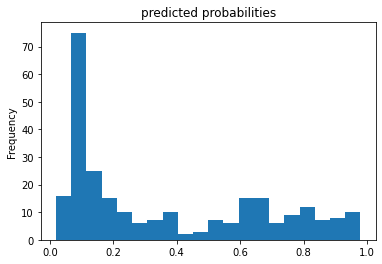

In [10]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

clear_output()  
probs.plot(kind='hist', bins=20, title='predicted probabilities')

## Classification - Iris dataset

In [11]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [12]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [13]:
def input_fn(features, labels, training=True, batch_size=256):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [14]:
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

print(my_feature_columns[0])

NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


In [15]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[30, 10],
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)

eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.933



## Neural Networks - fashion MNIST dataset

In [16]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [17]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

train_images.shape

(60000, 28, 28)

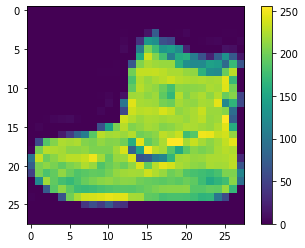

In [18]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.show()

In [19]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.4962 - accuracy: 0.8252
Epoch 2/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3746 - accuracy: 0.8652
Epoch 3/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.3352 - accuracy: 0.8781
Epoch 4/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.3112 - accuracy: 0.8854
Epoch 5/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2945 - accuracy: 0.8917


In [21]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2) 
print('Test accuracy:', test_acc)

10000/1 - 0s - loss: 0.2737 - accuracy: 0.8770
Test accuracy: 0.877


## RNN - Sentiment analysis with IMDB dataset

In [22]:
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing import sequence

Using TensorFlow backend.


In [23]:
VOCAB_SIZE = 88584
MAXLEN = 250
BATCH_SIZE = 64

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = VOCAB_SIZE)

In [24]:
train_data = sequence.pad_sequences(train_data, MAXLEN)
test_data = sequence.pad_sequences(test_data, MAXLEN)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          2834688   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,843,041
Trainable params: 2,843,041
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['acc'])
model.fit(train_data, train_labels, epochs=1, validation_split=0.2)

results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

Train on 20000 samples, validate on 5000 samples
20000/20000 [==============================] - 13s 649us/sample - loss: 0.4235 - acc: 0.8053 - val_loss: 0.3402 - val_acc: 0.8556
25000/1 - 7s - loss: 0.3261 - acc: 0.8438
[0.36459608827590945, 0.8438]


In [27]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}

def encode_text(text):
    tokens = keras.preprocessing.text.text_to_word_sequence(text)
    tokens = [word_index[word] if word in word_index else 0 for word in tokens]
    return sequence.pad_sequences([tokens], MAXLEN)[0]

def decode_integers(integers):
    PAD = 0
    text = ""
    for num in integers:
        if num != PAD:
            text += reverse_word_index[num] + " "
    return text[:-1]

In [28]:
text = "that movie was just amazing, so amazing"
encoded = encode_text(text)

print(encoded[-7:]) # ignore the pads
print(decode_integers(encoded))

[ 12  17  13  40 477  35 477]
that movie was just amazing so amazing


In [29]:
def predict(text):
    encoded_text = encode_text(text)
    pred = np.zeros((1,250))
    pred[0] = encoded_text
    result = model.predict(pred) 
    print(result[0])

positive_review = "That movie was! really loved it and would great watch it again because it was amazingly great"
predict(positive_review)

negative_review = "that movie really sucked. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched"
predict(negative_review)

[0.79766613]
[0.21395327]


## RNN - Shakespeare play generator

In [30]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [31]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [32]:
vocab = sorted(set(text))

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
    return np.array([char2idx[c] for c in text])

def int_to_text(ints):
    try:
        ints = ints.numpy()
    except:
        pass
    return ''.join(idx2char[ints])

In [33]:
text_as_int = text_to_int(text)

print(text[:13])
print(text_as_int[:13])
print(int_to_text(text_as_int[:13]))

First Citizen
[18 47 56 57 58  1 15 47 58 47 64 43 52]
First Citizen


In [34]:
seq_length = 100  # length of sequence for a training example
examples_per_epoch = len(text) // (seq_length+1)

def split_input_target(chunk):  # for the example: hello
    input_text = chunk[:-1]  # hell
    target_text = chunk[1:]  # ello
    return input_text, target_text  # hell, ello


# Create training examples and targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
dataset = sequences.map(split_input_target)

In [35]:
for x, y in dataset.take(1):
    print("INPUT\n")
    print(int_to_text(x))
    print("\nOUTPUT\n")
    print(int_to_text(y))

INPUT

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

OUTPUT

irst Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 


In [37]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab)  # vocab is number of unique characters
EMBEDDING_DIM = 256
RNN_UNITS = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)])
    return model

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [38]:
model = build_model(VOCAB_SIZE,EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_4 (Dense)              (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [39]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
history = model.fit(data, epochs=2, callbacks=[checkpoint_callback])

Epoch 1/2
172/172 [==============================] - 18s 103ms/step - loss: 2.5625
Epoch 2/2
172/172 [==============================] - 16s 96ms/step - loss: 1.8689


In [40]:
# for prediction with arbitrary input length
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [41]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 800

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension

        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [42]:
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: All:
All: 
HoRKZABISA:
The chermth.
Thit fells o hear in chill if hor
Where alt there an theirthel sreming,
The me'd and not thine your ipprarceare
And cricedon on actuack yout Lain never
On yourrend her will sulfortious!
Which notlan ent my from go to a cerele:
Be, getless and that he stry prech o'e.
Becense poty and dupen ut, in out well fie, I make how batce,
Ih he repslimatees in chardain and gon'd no more
Of thou shold before thas both loth.

POONONENO:
Than!
Do, I'll tall Pefull frim,
I will have den your forturead, oe no common'e.
He lateenul I thank,
That to my hivene,
And sinrow not. What, 'for of the bonesine
Dood good me hame ropsow and canid it in thou:
Ind good the Laye, say; sit!
Have thy fairt wonimes 'To to Hergon of!

WhAWISG HARCIO:
De may vellown my higher enely.

CEMILEN-O:
Whyo
